#### **Vision Transformer**

Vision Transformers (ViTs) break down images into patches, which are then processed by a Transformer encoder to create a global representation for classification. ViTs demonstrate greater scalability than CNNs, and they significantly outperform ResNets when trained as larger models on larger datasets.

**Vision Transformer Architecture**

In the high-level architecture, we split the input images into patches, a special <cls> token and the flattened image patches are transformed via path embedding and n-transformer encoder blocks into 10 representations. The <cls> representation is further transformed into the output label.

Consider an input image with height h, width w, and c channels. Specifying the patch height and width as p, the image is split into a sequence of m = h*w/p^2, where each patch is flattened to a vector of length c*p^2. Image patches can be treated similarly to tokens in text sequences. A special <cls> class token and the m flattened image patches are linearly projected into a sequence of (m+1) vectors,
summed with learnable positional embeddings.


The multi-layer Transformer encoder transforms m+1 input vectors into the same amount of output vectors representations of the same length. It works exactly in the same way as the original Transformer encoder only differing in the position of normalization.


**Patch Embedding**

Split an image into patches and linearly project these flattened patches can be simplified as a single convolution operation, where both kernel and stride size are set to patch size

In [ ]:
import dl_modules

In [ ]:
class PatchEmbedding(nn.Module):
  def __init__(self, img_size=96, patch_size=16, num_hiddens=512):
      super().__init__()

      def _make_tuple(x):
          if not isinstance(x, (list, tuple)):
            return (x, x)
          return x

      img_size, patch_size = _make_tuple(img_size), _make_tuple(patch_size)
      self.num_patched = (img_size[0] // patch_size[0]) * (img_size[1] // patch_size[1])
      self.conv = nn.LazyConv2d(num_hiddens, kernel_size=patch_size, stride=patch_size)

  def forward(self, X):
      return self.conv(X).flatten(2).transpose(1, 2)

**Vision Transformer Encoder**

the MLP of the ViT encoder is slightly different from the position-wise-ffn of the original transformer encoder. Here we use Gaussian Linear Error (GELU) for activation function, and Dropout is applied at each fully connected layer in the MLP regularization

In [ ]:
class ViTMLP(nn.Module):
    def __init__(self, mlp_num_hiddens, mlp_num_outputs, dropout=0.5):
        super().__init__()
        self.dense1 = nn.LazyLinear(mlp_num_hiddens)
        self.gelu = nn.GELU()
        self.dropout1 = nn.Dropout(dropout)
        self.dense2 = nn.LazyLinear(mlp_num_outputs)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        return self.dropout2(self.dense2(self.dropout1(self.gelu(self.dense1(x)))))

**Interface Abstractions and Classes**

**Transformer Encoder Block**

For vision transformer encoder block we follow pre-normalization that is applied right before the multi-head attention as opposed to post-normalization that is placed after residual connection. For vision transformer this leads to more efficient training.

In [ ]:
class ViTBlock(nn.Module):
  def __init__(self, num_hiddens, norm_shape, mlp_num_hiddens, num_heads, dropout, use_bias=False):
      super().__init__()
      self.ln1 = nn.LayerNorm(norm_shape)
      self.attention = MultiHeadAttention(num_hiddens, num_heads, dropout, use_bias)
      self.ln2 = nn.LayerNorm(norm_shape)
      self.mlp = ViTMLP(mlp_num_hiddens, num_hiddens, dropout)

  def forward(self, X, valid_lens=None):
      X =  X + self.attention(*([self.ln1(X)] *3), valid_lens)
      return X + self.mlp(self.ln2(X))

In [ ]:
encoder_block = ViTBlock(24, 24, 48, 8, 0.5)
encoder_block.eval()

ViTBlock(
  (ln1): LayerNorm((24,), eps=1e-05, elementwise_affine=True)
  (attention): MultiHeadAttention(
    (attention): DotProductAttention(
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (W_q): LazyLinear(in_features=0, out_features=24, bias=False)
    (W_k): LazyLinear(in_features=0, out_features=24, bias=False)
    (W_v): LazyLinear(in_features=0, out_features=24, bias=False)
    (W_o): LazyLinear(in_features=0, out_features=24, bias=False)
  )
  (ln2): LayerNorm((24,), eps=1e-05, elementwise_affine=True)
  (mlp): ViTMLP(
    (dense1): LazyLinear(in_features=0, out_features=48, bias=True)
    (gelu): GELU(approximate='none')
    (dropout1): Dropout(p=0.5, inplace=False)
    (dense2): LazyLinear(in_features=0, out_features=24, bias=True)
    (dropout2): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
class MultiHeadAttention(Module):
  def __init__(
      self, num_hiddens, num_heads, dropout, bias=False, **kwargs):
    super().__init__()
    self.num_heads = num_heads
    self.attention = DotProductAttention(dropout)
    self.W_q = nn.LazyLinear(num_hiddens, bias=bias)
    self.W_k = nn.LazyLinear(num_hiddens, bias=bias)
    self.W_v = nn.LazyLinear(num_hiddens, bias=bias)
    self.W_o = nn.LazyLinear(num_hiddens, bias=bias)

  def transpose_qkv(self, X):
    X = X.reshape(X.shape[0], X.shape[1], self.num_heads, -1)
    X = X.permute(0, 2, 1, 3)
    return X.reshape(-1, X.shape[2], X.shape[3])

  def transpose_output(self, X):
    X = X.reshape(-1, self.num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

  def forward(self, queries, keys, values, valid_lens):
    queries = self.transpose_qkv(self.W_q(queries))
    keys = self.transpose_qkv(self.W_k(keys))
    values = self.transpose_qkv(self.W_v(values))

    if valid_lens is not None:
      valid_lens = torch.repeat_interleave(
          valid_lens, repeats=self.num_heads, dim=0)
    output = self.attention(queries, keys, values, valid_lens)
    output_concat = self.transpose_output(output)
    return self.W_o(output_concat)

In [ ]:
''' Dot-product attention & dropout for regularization '''
class DotProductAttention(nn.Module):
  def __init__(self, dropout):
    super().__init__()
    self.dropout = nn.Dropout(dropout)

  def forward(self, queries, keys, values, valid_lens=None):
    d = queries.shape[-1]
    scores = torch.bmm(queries, keys.transpose(1, 2)) /math.sqrt(d)
    self.attention_weights = masked_softmax(scores, valid_lens)
    return torch.bmm(self.dropout(self.attention_weights), values)

**Vision Transformer**

- Input images are fed into PatchEmbedding instance, whose output is concatenated with the <cls> class token embedding.
- They are summed with learnable positional embedding prior to the dropout.
- The output is fed into the Transformer encoder that stacks number of block instances of the ViT black class.
- The representation of the  cls token is projected by the network head

In [ ]:
class ViT(Classifier):
  def __init__(self, img_size, patch_size, num_hiddens, mlp_num_hiddens, num_heads, num_blks, emb_dropout, blk_dropout, lr=0.1, use_bias=False, num_classes=10):
      super().__init__()
      self.save_hyperparameters()
      self.patch_embedding = PatchEmbedding(img_size, patch_size, num_hiddens)
      self.cls_token = nn.Parameter(torch.zeros(1, 1, num_hiddens))
      num_steps = self.patch_embedding.num_patched + 1
      self.pos_embedding = nn.Parameter(torch.randn(1, num_steps, num_hiddens))
      self.dropout = nn.Dropout(emb_dropout)
      self.blks = nn.Sequential()
      for i in range(num_blks):
          self.blks.add_module(f'{i}', ViTBlock(num_hiddens, num_hiddens, mlp_num_hiddens, num_heads, blk_dropout, use_bias))
      self.head = nn.Sequential(nn.LayerNorm(num_hiddens),
                                nn.Linear(num_hiddens, num_classes))

  def forward(self, X):
      X = self.patch_embedding(X)
      X = torch.cat((self.cls_token.expand(X.shape[0], -1, -1), X), 1)
      X = self.dropout(X + self.pos_embedding)
      for blk in self.blks:
          X = blk(X)
      return self.head(X[:, 0])

**Training**

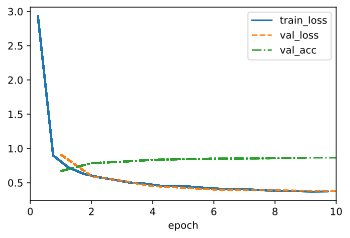

In [ ]:
''' We will train the Vision Transformer on Fashion-MNIST dataset '''
img_size, patch_size = 96, 16
num_hiddens, mlp_num_hiddens, num_heads, num_blks = 512, 2048, 8, 2
emb_dropout, blk_dropout, lr = 0.1, 0.1, 0.1
model = ViT(img_size, patch_size, num_hiddens, mlp_num_hiddens, num_heads,
            num_blks, emb_dropout, blk_dropout, lr)
trainer = Trainer(max_epochs=10, num_gpus=1)
data = FashionMNIST(batch_size=128, resize=(img_size, img_size))
trainer.fit(model, data)

**Discussion**

When trained on small datasets like Fashion-MNIST, our Vision Transformer (ViT) does not outperform ResNet. This is attributed to the fact that ViTs lack the inherent principles of convolutions, specifically **translation invariance and locality**.

However, the situation changes when training larger models on massive datasets (with hundreds of millions of images). In this scenario, the ViT significantly outperforms ResNet in image classification, demonstrating **the intrinsic superiority of Transformers in terms of scalability**.

ViTs have fundamentally altered the landscape of network design for image data. To create a general-purpose backbone for computer vision, Swin Transformers were introduced to address two key limitations:

**Quadratic computational complexity **with respect to image size.

The absence of convolution-like inductive biases.

By adding back convolution-like priors, **Swin Transformers** have extended the applicability of Transformers to a wide range of computer vision tasks beyond just image classification, **achieving state-of-the-art results**.